# LightGBM
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

### Prediction: *level*

## Loading data

In [50]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
features = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=features,
)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   cha         1206 non-null   int64 
 1   wis         1206 non-null   int64 
 2   perception  1206 non-null   int64 
 3   book        1206 non-null   object
 4   con         1206 non-null   int64 
 5   focus       1206 non-null   int32 
 6   hp          1206 non-null   int64 
 7   will        1206 non-null   int64 
 8   ac          1206 non-null   int64 
 9   fortitude   1206 non-null   int64 
 10  int         1206 non-null   int64 
 11  str         1206 non-null   int64 
 12  dex         1206 non-null   int64 
 13  reflex      1206 non-null   int64 
 14  level       1206 non-null   int64 
dtypes: int32(1), int64(13), object(1)
memory usage: 146.0+ KB


In [52]:
df.head()

,cha,wis,perception,book,con,focus,hp,will,ac,fortitude,int,str,dex,reflex,level
0,1,2,20,Pathfinder Bestiary,5,1,215,17,29,22,1,7,2,19,10
1,1,2,16,Pathfinder Bestiary,5,0,220,16,28,21,-4,9,0,14,10
2,-2,3,17,Pathfinder Bestiary,6,0,175,15,25,20,-4,7,3,17,8
3,6,5,30,Pathfinder Bestiary,5,1,315,32,41,30,6,7,4,29,17
4,1,1,6,Pathfinder Bestiary,1,1,20,4,16,6,-1,-5,3,10,1


###### Level

In [53]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [54]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [55]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


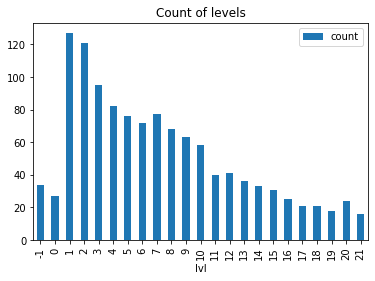

In [56]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [57]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [58]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [59]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [60]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [61]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 13
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [62]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.26
RMSE: 0.51
MAE: 0.36


In [64]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Set of features": [],
        "MSE": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "default", "expanded", mse, rmse, mae]

In [65]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.21
RMSE test: 0.51


###### MAE by level

In [66]:
from training.results import plot_mae_by_level

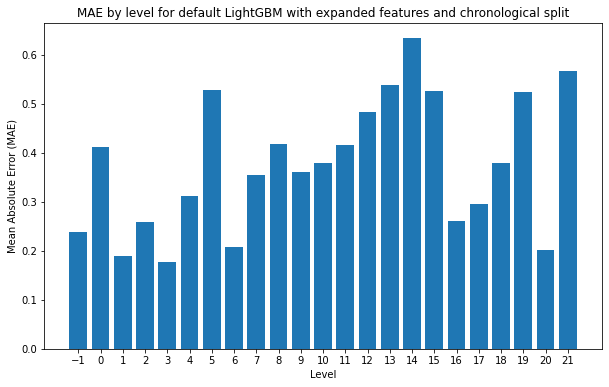

In [67]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for default LightGBM with expanded features and chronological split",
)

In [68]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Normal:
MSE: 0.26
RMSE: 0.51

Round type: round
MSE: 0.30
RMSE: 0.55

Round type: 0.33
MSE: 0.29
RMSE: 0.54

Round type: 0.45
MSE: 0.29
RMSE: 0.54



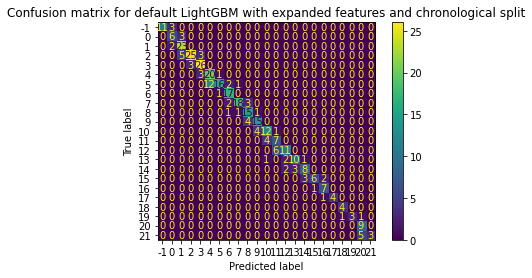

In [69]:
plot_confusion_matrix(
    "round",
    y_pred_test,
    y_test,
    title="Confusion matrix for default LightGBM with expanded features and chronological split",
)

#### Tuning

In [70]:
from training.results import assess_regression_model

In [71]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-04 19:52:38,135] A new study created in memory with name: no-name-1285cb7a-7cd0-4f49-913a-6f8cb3c6eff4
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.183573 + 0.0398666
[200]	cv_agg's l2: 0.179042 + 0.0386216
[300]	cv_agg's l2: 0.179231 + 0.0380819


feature_fraction, val_score: 0.178542:  14%|######4                                      | 1/7 [00:06<00:37,  6.19s/it]

Early stopping, best iteration is:
[230]	cv_agg's l2: 0.178542 + 0.0381337
[100]	cv_agg's l2: 0.176994 + 0.0337436
[200]	cv_agg's l2: 0.173299 + 0.0333576


feature_fraction, val_score: 0.173074:  29%|############8                                | 2/7 [00:10<00:25,  5.02s/it]

Early stopping, best iteration is:
[175]	cv_agg's l2: 0.173074 + 0.0335446
[100]	cv_agg's l2: 0.174235 + 0.0350545
[200]	cv_agg's l2: 0.170979 + 0.033012


feature_fraction, val_score: 0.170501:  43%|###################2                         | 3/7 [00:14<00:18,  4.59s/it]

Early stopping, best iteration is:
[160]	cv_agg's l2: 0.170501 + 0.0330227
[100]	cv_agg's l2: 0.188451 + 0.039066
[200]	cv_agg's l2: 0.185932 + 0.0365916


feature_fraction, val_score: 0.170501:  57%|#########################7                   | 4/7 [00:18<00:12,  4.18s/it]

Early stopping, best iteration is:
[160]	cv_agg's l2: 0.170501 + 0.0330227
[100]	cv_agg's l2: 0.182664 + 0.0389225
[200]	cv_agg's l2: 0.180001 + 0.0361941


feature_fraction, val_score: 0.170501:  71%|################################1            | 5/7 [00:21<00:07,  3.90s/it]

Early stopping, best iteration is:
[160]	cv_agg's l2: 0.170501 + 0.0330227
[100]	cv_agg's l2: 0.160939 + 0.0268114
[200]	cv_agg's l2: 0.159004 + 0.0248617


feature_fraction, val_score: 0.158673:  86%|######################################5      | 6/7 [00:24<00:03,  3.73s/it]

Early stopping, best iteration is:
[185]	cv_agg's l2: 0.158673 + 0.0243201
[100]	cv_agg's l2: 0.182552 + 0.0433539
[200]	cv_agg's l2: 0.179358 + 0.0413495


feature_fraction, val_score: 0.158673: 100%|#############################################| 7/7 [00:28<00:00,  4.07s/it]


Early stopping, best iteration is:
[185]	cv_agg's l2: 0.158673 + 0.0243201


num_leaves, val_score: 0.158673:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.160939 + 0.0268114
[200]	cv_agg's l2: 0.159004 + 0.0248617


num_leaves, val_score: 0.158673:   5%|##5                                               | 1/20 [00:03<01:04,  3.38s/it]

Early stopping, best iteration is:
[185]	cv_agg's l2: 0.158673 + 0.0243201
[100]	cv_agg's l2: 0.160939 + 0.0268114
[200]	cv_agg's l2: 0.159004 + 0.0248617


num_leaves, val_score: 0.158673:  10%|#####                                             | 2/20 [00:06<01:01,  3.39s/it]

Early stopping, best iteration is:
[185]	cv_agg's l2: 0.158673 + 0.0243201
[100]	cv_agg's l2: 0.160939 + 0.0268114
[200]	cv_agg's l2: 0.159004 + 0.0248617


num_leaves, val_score: 0.158673:  15%|#######5                                          | 3/20 [00:10<00:57,  3.37s/it]

Early stopping, best iteration is:
[185]	cv_agg's l2: 0.158673 + 0.0243201
[100]	cv_agg's l2: 0.160939 + 0.0268114
[200]	cv_agg's l2: 0.159004 + 0.0248617


num_leaves, val_score: 0.158673:  20%|##########                                        | 4/20 [00:13<00:54,  3.38s/it]

Early stopping, best iteration is:
[185]	cv_agg's l2: 0.158673 + 0.0243201
[100]	cv_agg's l2: 0.160939 + 0.0268114
[200]	cv_agg's l2: 0.159004 + 0.0248617


num_leaves, val_score: 0.158673:  25%|############5                                     | 5/20 [00:16<00:50,  3.37s/it]

Early stopping, best iteration is:
[185]	cv_agg's l2: 0.158673 + 0.0243201
[100]	cv_agg's l2: 0.160939 + 0.0268114
[200]	cv_agg's l2: 0.159004 + 0.0248617


num_leaves, val_score: 0.158673:  30%|###############                                   | 6/20 [00:20<00:47,  3.36s/it]

Early stopping, best iteration is:
[185]	cv_agg's l2: 0.158673 + 0.0243201
[100]	cv_agg's l2: 0.198824 + 0.0177961
[200]	cv_agg's l2: 0.175844 + 0.0140668


num_leaves, val_score: 0.158673:  35%|#################5                                | 7/20 [00:21<00:33,  2.60s/it]

Early stopping, best iteration is:
[185]	cv_agg's l2: 0.158673 + 0.0243201
[100]	cv_agg's l2: 0.160939 + 0.0268114
[200]	cv_agg's l2: 0.159004 + 0.0248617


num_leaves, val_score: 0.158673:  40%|####################                              | 8/20 [00:24<00:34,  2.86s/it]

Early stopping, best iteration is:
[185]	cv_agg's l2: 0.158673 + 0.0243201
[100]	cv_agg's l2: 0.160939 + 0.0268114
[200]	cv_agg's l2: 0.159004 + 0.0248617


num_leaves, val_score: 0.158673:  45%|######################5                           | 9/20 [00:28<00:33,  3.06s/it]

Early stopping, best iteration is:
[185]	cv_agg's l2: 0.158673 + 0.0243201
[100]	cv_agg's l2: 0.160939 + 0.0268114
[200]	cv_agg's l2: 0.159004 + 0.0248617


num_leaves, val_score: 0.158673:  50%|########################5                        | 10/20 [00:31<00:31,  3.16s/it]

Early stopping, best iteration is:
[185]	cv_agg's l2: 0.158673 + 0.0243201
[100]	cv_agg's l2: 0.160939 + 0.0268114
[200]	cv_agg's l2: 0.159004 + 0.0248617


num_leaves, val_score: 0.158673:  55%|##########################9                      | 11/20 [00:34<00:29,  3.25s/it]

Early stopping, best iteration is:
[185]	cv_agg's l2: 0.158673 + 0.0243201
[100]	cv_agg's l2: 0.160939 + 0.0268114
[200]	cv_agg's l2: 0.159004 + 0.0248617


num_leaves, val_score: 0.158673:  60%|#############################4                   | 12/20 [00:38<00:27,  3.45s/it]

Early stopping, best iteration is:
[185]	cv_agg's l2: 0.158673 + 0.0243201
[100]	cv_agg's l2: 0.160243 + 0.0272878
[200]	cv_agg's l2: 0.158944 + 0.0260491


num_leaves, val_score: 0.158333:  65%|###############################8                 | 13/20 [00:42<00:23,  3.38s/it]

Early stopping, best iteration is:
[122]	cv_agg's l2: 0.158333 + 0.0272746
[100]	cv_agg's l2: 0.198824 + 0.0177961


num_leaves, val_score: 0.158333:  70%|##################################3              | 14/20 [00:42<00:15,  2.59s/it]

[200]	cv_agg's l2: 0.175844 + 0.0140668
Early stopping, best iteration is:
[122]	cv_agg's l2: 0.158333 + 0.0272746
[100]	cv_agg's l2: 0.160939 + 0.0268114
[200]	cv_agg's l2: 0.159004 + 0.0248617


num_leaves, val_score: 0.158333:  75%|####################################7            | 15/20 [00:45<00:13,  2.67s/it]

Early stopping, best iteration is:
[122]	cv_agg's l2: 0.158333 + 0.0272746
[100]	cv_agg's l2: 0.160939 + 0.0268114
[200]	cv_agg's l2: 0.159004 + 0.0248617


num_leaves, val_score: 0.158333:  80%|#######################################2         | 16/20 [00:48<00:10,  2.71s/it]

Early stopping, best iteration is:
[122]	cv_agg's l2: 0.158333 + 0.0272746
[100]	cv_agg's l2: 0.160939 + 0.0268114
[200]	cv_agg's l2: 0.159004 + 0.0248617


num_leaves, val_score: 0.158333:  85%|#########################################6       | 17/20 [00:51<00:07,  2.67s/it]

Early stopping, best iteration is:
[122]	cv_agg's l2: 0.158333 + 0.0272746
[100]	cv_agg's l2: 0.160939 + 0.0268114
[200]	cv_agg's l2: 0.159004 + 0.0248617


num_leaves, val_score: 0.158333:  90%|############################################1    | 18/20 [00:53<00:05,  2.69s/it]

Early stopping, best iteration is:
[122]	cv_agg's l2: 0.158333 + 0.0272746
[100]	cv_agg's l2: 0.160939 + 0.0268114
[200]	cv_agg's l2: 0.159004 + 0.0248617


num_leaves, val_score: 0.158333:  95%|##############################################5  | 19/20 [00:56<00:02,  2.69s/it]

Early stopping, best iteration is:
[122]	cv_agg's l2: 0.158333 + 0.0272746
[100]	cv_agg's l2: 0.160939 + 0.0268114
[200]	cv_agg's l2: 0.159004 + 0.0248617


num_leaves, val_score: 0.158333: 100%|#################################################| 20/20 [00:59<00:00,  2.96s/it]


Early stopping, best iteration is:
[122]	cv_agg's l2: 0.158333 + 0.0272746


bagging, val_score: 0.158333:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.209483 + 0.0280606


bagging, val_score: 0.158333:   0%|                                                             | 0/10 [00:01<?, ?it/s]

[200]	cv_agg's l2: 0.196286 + 0.028136
Early stopping, best iteration is:
[122]	cv_agg's l2: 0.158333 + 0.0272746


bagging, val_score: 0.158333:  10%|#####3                                               | 1/10 [00:01<00:14,  1.58s/it]

[100]	cv_agg's l2: 0.165009 + 0.02854
[200]	cv_agg's l2: 0.162739 + 0.0281469


bagging, val_score: 0.158333:  20%|##########6                                          | 2/10 [00:04<00:17,  2.13s/it]

Early stopping, best iteration is:
[122]	cv_agg's l2: 0.158333 + 0.0272746
[100]	cv_agg's l2: 0.209466 + 0.0214357


bagging, val_score: 0.158333:  30%|###############9                                     | 3/10 [00:05<00:12,  1.80s/it]

[200]	cv_agg's l2: 0.194176 + 0.0178181
Early stopping, best iteration is:
[122]	cv_agg's l2: 0.158333 + 0.0272746
[100]	cv_agg's l2: 0.17654 + 0.0251544
[200]	cv_agg's l2: 0.171048 + 0.0220202


bagging, val_score: 0.158333:  40%|#####################2                               | 4/10 [00:07<00:12,  2.02s/it]

Early stopping, best iteration is:
[122]	cv_agg's l2: 0.158333 + 0.0272746
[100]	cv_agg's l2: 0.182997 + 0.024688


bagging, val_score: 0.158333:  40%|#####################2                               | 4/10 [00:09<00:12,  2.02s/it]

[200]	cv_agg's l2: 0.176365 + 0.0220269
Early stopping, best iteration is:
[122]	cv_agg's l2: 0.158333 + 0.0272746


bagging, val_score: 0.158333:  50%|##########################5                          | 5/10 [00:09<00:09,  2.00s/it]

[100]	cv_agg's l2: 0.162083 + 0.025713
[200]	cv_agg's l2: 0.160358 + 0.0239722


bagging, val_score: 0.158333:  60%|###############################8                     | 6/10 [00:12<00:08,  2.18s/it]

Early stopping, best iteration is:
[122]	cv_agg's l2: 0.158333 + 0.0272746
[100]	cv_agg's l2: 0.185727 + 0.0223372


bagging, val_score: 0.158333:  70%|#####################################                | 7/10 [00:14<00:06,  2.01s/it]

[200]	cv_agg's l2: 0.178085 + 0.0182503
Early stopping, best iteration is:
[122]	cv_agg's l2: 0.158333 + 0.0272746
[100]	cv_agg's l2: 0.172955 + 0.0250372
[200]	cv_agg's l2: 0.167013 + 0.0225842


bagging, val_score: 0.158333:  80%|##########################################4          | 8/10 [00:16<00:04,  2.10s/it]

Early stopping, best iteration is:
[122]	cv_agg's l2: 0.158333 + 0.0272746
[100]	cv_agg's l2: 0.199443 + 0.0271936


bagging, val_score: 0.158333:  90%|###############################################7     | 9/10 [00:18<00:01,  2.00s/it]

[200]	cv_agg's l2: 0.189667 + 0.0242885
Early stopping, best iteration is:
[122]	cv_agg's l2: 0.158333 + 0.0272746
[100]	cv_agg's l2: 0.168235 + 0.0202722
[200]	cv_agg's l2: 0.16394 + 0.0183074


bagging, val_score: 0.158333: 100%|####################################################| 10/10 [00:20<00:00,  2.07s/it]


Early stopping, best iteration is:
[122]	cv_agg's l2: 0.158333 + 0.0272746


feature_fraction_stage2, val_score: 0.158333:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.166486 + 0.0226133
[200]	cv_agg's l2: 0.162785 + 0.0217481


feature_fraction_stage2, val_score: 0.158333:  33%|############6                         | 1/3 [00:02<00:05,  2.63s/it]

Early stopping, best iteration is:
[122]	cv_agg's l2: 0.158333 + 0.0272746
[100]	cv_agg's l2: 0.160243 + 0.0272878
[200]	cv_agg's l2: 0.158944 + 0.0260491


feature_fraction_stage2, val_score: 0.158333:  67%|#########################3            | 2/3 [00:05<00:02,  2.64s/it]

Early stopping, best iteration is:
[122]	cv_agg's l2: 0.158333 + 0.0272746
[100]	cv_agg's l2: 0.166486 + 0.0226133
[200]	cv_agg's l2: 0.162785 + 0.0217481


feature_fraction_stage2, val_score: 0.158333: 100%|######################################| 3/3 [00:07<00:00,  2.63s/it]


Early stopping, best iteration is:
[122]	cv_agg's l2: 0.158333 + 0.0272746


regularization_factors, val_score: 0.158333:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.160048 + 0.0270616
[200]	cv_agg's l2: 0.159133 + 0.0256394


regularization_factors, val_score: 0.158333:   5%|#9                                    | 1/20 [00:03<00:58,  3.10s/it]

Early stopping, best iteration is:
[122]	cv_agg's l2: 0.158333 + 0.0272746
[100]	cv_agg's l2: 0.159914 + 0.0269936
[200]	cv_agg's l2: 0.159793 + 0.0265237


regularization_factors, val_score: 0.158333:  10%|###8                                  | 2/20 [00:06<01:02,  3.49s/it]

Early stopping, best iteration is:
[122]	cv_agg's l2: 0.158333 + 0.0272746
[100]	cv_agg's l2: 0.160037 + 0.0237958
[200]	cv_agg's l2: 0.159344 + 0.023246


regularization_factors, val_score: 0.158245:  15%|#####7                                | 3/20 [00:09<00:55,  3.29s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.158245 + 0.0221549
[100]	cv_agg's l2: 0.161918 + 0.0231085
[200]	cv_agg's l2: 0.159554 + 0.0229264


regularization_factors, val_score: 0.158245:  20%|#######6                              | 4/20 [00:12<00:49,  3.12s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.158245 + 0.0221549
[100]	cv_agg's l2: 0.161361 + 0.0277594
[200]	cv_agg's l2: 0.159966 + 0.0264766


regularization_factors, val_score: 0.158245:  25%|#########5                            | 5/20 [00:15<00:46,  3.09s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.158245 + 0.0221549
[100]	cv_agg's l2: 0.168303 + 0.0284082
[200]	cv_agg's l2: 0.162257 + 0.0245621


regularization_factors, val_score: 0.158245:  30%|###########4                          | 6/20 [00:18<00:40,  2.86s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.158245 + 0.0221549
[100]	cv_agg's l2: 0.173446 + 0.023175
[200]	cv_agg's l2: 0.164113 + 0.0225173


regularization_factors, val_score: 0.158245:  35%|#############3                        | 7/20 [00:20<00:36,  2.83s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.158245 + 0.0221549
[100]	cv_agg's l2: 0.159721 + 0.0269877
[200]	cv_agg's l2: 0.158548 + 0.0259902


regularization_factors, val_score: 0.158026:  40%|###############2                      | 8/20 [00:24<00:35,  2.98s/it]

Early stopping, best iteration is:
[187]	cv_agg's l2: 0.158026 + 0.0256652
[100]	cv_agg's l2: 0.161215 + 0.0277228
[200]	cv_agg's l2: 0.15965 + 0.026508


regularization_factors, val_score: 0.158026:  45%|#################1                    | 9/20 [00:28<00:36,  3.33s/it]

Early stopping, best iteration is:
[187]	cv_agg's l2: 0.158026 + 0.0256652
[100]	cv_agg's l2: 0.16003 + 0.0274317
[200]	cv_agg's l2: 0.158871 + 0.0261923


regularization_factors, val_score: 0.158026:  50%|##################5                  | 10/20 [00:32<00:34,  3.49s/it]

Early stopping, best iteration is:
[187]	cv_agg's l2: 0.158026 + 0.0256652
[100]	cv_agg's l2: 0.162313 + 0.0263012
[200]	cv_agg's l2: 0.161654 + 0.0257281


regularization_factors, val_score: 0.158026:  55%|####################3                | 11/20 [00:35<00:31,  3.50s/it]

Early stopping, best iteration is:
[187]	cv_agg's l2: 0.158026 + 0.0256652
[100]	cv_agg's l2: 0.16003 + 0.0274317
[200]	cv_agg's l2: 0.158901 + 0.0261904


regularization_factors, val_score: 0.158026:  60%|######################2              | 12/20 [00:39<00:28,  3.52s/it]

Early stopping, best iteration is:
[187]	cv_agg's l2: 0.158026 + 0.0256652
[100]	cv_agg's l2: 0.160557 + 0.0282409
[200]	cv_agg's l2: 0.158643 + 0.0271244


regularization_factors, val_score: 0.158000:  65%|########################             | 13/20 [00:42<00:23,  3.40s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.158 + 0.026503
[100]	cv_agg's l2: 0.159494 + 0.0276053
[200]	cv_agg's l2: 0.157642 + 0.0261685


regularization_factors, val_score: 0.156816:  70%|#########################9           | 14/20 [00:45<00:19,  3.33s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.156816 + 0.0259966
[100]	cv_agg's l2: 0.160672 + 0.026858
[200]	cv_agg's l2: 0.159011 + 0.0257309


regularization_factors, val_score: 0.156816:  75%|###########################7         | 15/20 [00:48<00:16,  3.30s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.156816 + 0.0259966
[100]	cv_agg's l2: 0.159749 + 0.0239952
[200]	cv_agg's l2: 0.157751 + 0.0219422


regularization_factors, val_score: 0.156816:  80%|#############################6       | 16/20 [00:52<00:13,  3.28s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.156816 + 0.0259966
[100]	cv_agg's l2: 0.161613 + 0.026362
[200]	cv_agg's l2: 0.159493 + 0.0247393


regularization_factors, val_score: 0.156816:  85%|###############################4     | 17/20 [00:55<00:09,  3.19s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.156816 + 0.0259966
[100]	cv_agg's l2: 0.159494 + 0.0276051
[200]	cv_agg's l2: 0.157392 + 0.025761


regularization_factors, val_score: 0.156622:  90%|#################################3   | 18/20 [00:58<00:06,  3.34s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.156622 + 0.0259806
[100]	cv_agg's l2: 0.160205 + 0.0270267
[200]	cv_agg's l2: 0.158367 + 0.0257289


regularization_factors, val_score: 0.156622:  95%|###################################1 | 19/20 [01:02<00:03,  3.34s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.156622 + 0.0259806
[100]	cv_agg's l2: 0.159497 + 0.0262938
[200]	cv_agg's l2: 0.157989 + 0.0263421


regularization_factors, val_score: 0.156622: 100%|#####################################| 20/20 [01:05<00:00,  3.27s/it]


Early stopping, best iteration is:
[166]	cv_agg's l2: 0.156622 + 0.0259806


min_data_in_leaf, val_score: 0.156622:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.144356 + 0.0210213
[200]	cv_agg's l2: 0.142142 + 0.0197487


min_data_in_leaf, val_score: 0.141772:  20%|#########                                    | 1/5 [00:03<00:13,  3.36s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.141772 + 0.0198507
[100]	cv_agg's l2: 0.736689 + 0.104169


min_data_in_leaf, val_score: 0.141772:  20%|#########                                    | 1/5 [00:04<00:13,  3.36s/it]

[200]	cv_agg's l2: 0.714035 + 0.107883
Early stopping, best iteration is:
[159]	cv_agg's l2: 0.141772 + 0.0198507


min_data_in_leaf, val_score: 0.141772:  40%|##################                           | 2/5 [00:04<00:05,  1.93s/it]

[100]	cv_agg's l2: 0.14552 + 0.0200967
[200]	cv_agg's l2: 0.142055 + 0.0197174
[300]	cv_agg's l2: 0.142084 + 0.0198998


min_data_in_leaf, val_score: 0.141520:  60%|###########################                  | 3/5 [00:08<00:06,  3.07s/it]

Early stopping, best iteration is:
[244]	cv_agg's l2: 0.14152 + 0.0200423
[100]	cv_agg's l2: 0.173878 + 0.0273446
[200]	cv_agg's l2: 0.168858 + 0.0231303
[300]	cv_agg's l2: 0.168382 + 0.0230387


min_data_in_leaf, val_score: 0.141520:  80%|####################################         | 4/5 [00:12<00:03,  3.41s/it]

Early stopping, best iteration is:
[244]	cv_agg's l2: 0.14152 + 0.0200423
[100]	cv_agg's l2: 0.236154 + 0.0268227
[200]	cv_agg's l2: 0.220156 + 0.0321847
[300]	cv_agg's l2: 0.215861 + 0.0346807


min_data_in_leaf, val_score: 0.141520: 100%|#############################################| 5/5 [00:14<00:00,  2.94s/it]

Early stopping, best iteration is:
[244]	cv_agg's l2: 0.14152 + 0.0200423


In [72]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.1415195579306136
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.0038249872169225855
    lambda_l2: 0.0007868863371538626
    num_leaves: 23
    feature_fraction: 0.4
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 10


In [73]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [74]:
rmse, mse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.46
MSE test: 0.21
MAE test: 0.33



In [75]:
results.loc[1] = [
    "chronological",
    "Optuna",
    "expanded",
    mse,
    rmse,
    mae,
]

###### MAE by level

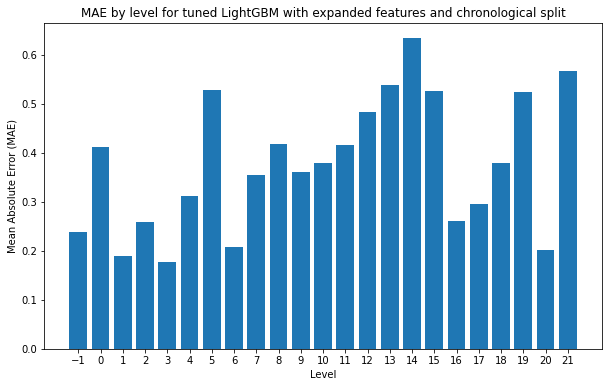

In [76]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for tuned LightGBM with expanded features and chronological split",
)

In [77]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.21
RMSE: 0.46

Round type: round
MSE: 0.24
RMSE: 0.49

Round type: 0.33
MSE: 0.25
RMSE: 0.50

Round type: 0.45
MSE: 0.24
RMSE: 0.49



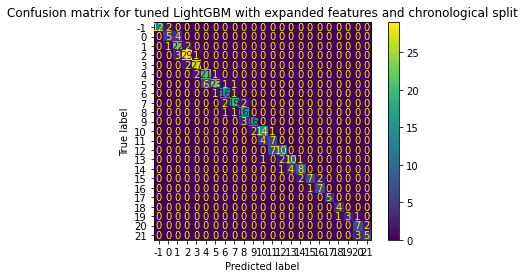

In [78]:
plot_confusion_matrix(
    "round",
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with expanded features and chronological split",
)

## Random split

In [79]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 392
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 13
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[88]	valid_0's l1: 0.267273	valid_0's l2: 0.148111


In [80]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [81]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.15
RMSE: 0.38
MAE: 0.27


In [82]:
results.loc[2] = ["random", "default", "expanded", mse, rmse, mae]

###### MAE by level

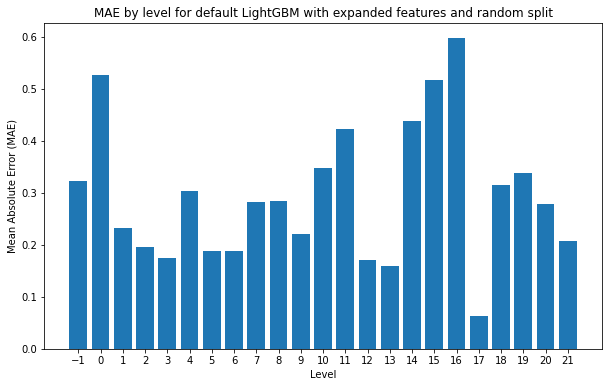

In [83]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for default LightGBM with expanded features and random split",
)

In [84]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Normal:
MSE: 0.15
RMSE: 0.38

Round type: round
MSE: 0.15
RMSE: 0.39

Round type: 0.33
MSE: 0.21
RMSE: 0.45

Round type: 0.45
MSE: 0.17
RMSE: 0.41



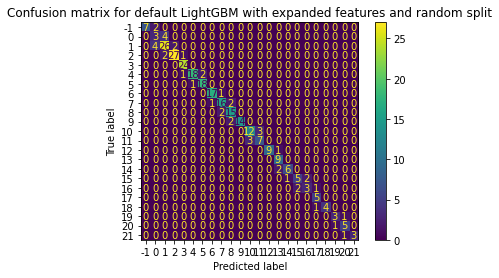

In [85]:
plot_confusion_matrix(
    "round",
    y_pred_test,
    y_test_random_split,
    title="Confusion matrix for default LightGBM with expanded features and random split",
)

### Tuning

In [86]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-04 19:56:14,100] A new study created in memory with name: no-name-dfe7237d-bef8-40c1-a1b2-e9e48df9fa12
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.17843 + 0.0475402
[200]	cv_agg's l2: 0.176202 + 0.0443822


feature_fraction, val_score: 0.176027:  14%|######4                                      | 1/7 [00:04<00:24,  4.12s/it]

[300]	cv_agg's l2: 0.177334 + 0.0439612
Early stopping, best iteration is:
[211]	cv_agg's l2: 0.176027 + 0.0441033
[100]	cv_agg's l2: 0.193498 + 0.0481775
[200]	cv_agg's l2: 0.191187 + 0.0444983


feature_fraction, val_score: 0.176027:  29%|############8                                | 2/7 [00:08<00:20,  4.19s/it]

[300]	cv_agg's l2: 0.191962 + 0.0433211
Early stopping, best iteration is:
[211]	cv_agg's l2: 0.176027 + 0.0441033
[100]	cv_agg's l2: 0.178675 + 0.0455247
[200]	cv_agg's l2: 0.178056 + 0.0429543


feature_fraction, val_score: 0.176027:  43%|###################2                         | 3/7 [00:12<00:17,  4.32s/it]

[300]	cv_agg's l2: 0.17887 + 0.041101
Early stopping, best iteration is:
[211]	cv_agg's l2: 0.176027 + 0.0441033
[100]	cv_agg's l2: 0.189366 + 0.0477434
[200]	cv_agg's l2: 0.186178 + 0.0437624


feature_fraction, val_score: 0.176027:  57%|#########################7                   | 4/7 [00:17<00:13,  4.35s/it]

[300]	cv_agg's l2: 0.186775 + 0.0423966
Early stopping, best iteration is:
[211]	cv_agg's l2: 0.176027 + 0.0441033
[100]	cv_agg's l2: 0.193746 + 0.0445184
[200]	cv_agg's l2: 0.189696 + 0.0411612


feature_fraction, val_score: 0.176027:  71%|################################1            | 5/7 [00:23<00:09,  4.97s/it]

[300]	cv_agg's l2: 0.18996 + 0.0395298
Early stopping, best iteration is:
[211]	cv_agg's l2: 0.176027 + 0.0441033
[100]	cv_agg's l2: 0.167619 + 0.0306238
[200]	cv_agg's l2: 0.166308 + 0.0282845


feature_fraction, val_score: 0.165822:  86%|######################################5      | 6/7 [00:26<00:04,  4.52s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.165822 + 0.0285272
[100]	cv_agg's l2: 0.189919 + 0.0468699
[200]	cv_agg's l2: 0.187937 + 0.0444818


feature_fraction, val_score: 0.165822: 100%|#############################################| 7/7 [00:30<00:00,  4.39s/it]


Early stopping, best iteration is:
[166]	cv_agg's l2: 0.165822 + 0.0285272


num_leaves, val_score: 0.165822:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.167619 + 0.0306238
[200]	cv_agg's l2: 0.166308 + 0.0282845


num_leaves, val_score: 0.165822:   5%|##5                                               | 1/20 [00:03<01:07,  3.56s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.165822 + 0.0285272
[100]	cv_agg's l2: 0.167619 + 0.0306238
[200]	cv_agg's l2: 0.166308 + 0.0282845


num_leaves, val_score: 0.165822:  10%|#####                                             | 2/20 [00:06<01:02,  3.45s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.165822 + 0.0285272
[100]	cv_agg's l2: 0.168643 + 0.0309421
[200]	cv_agg's l2: 0.166954 + 0.0284888


num_leaves, val_score: 0.165822:  15%|#######5                                          | 3/20 [00:10<00:58,  3.42s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.165822 + 0.0285272
[100]	cv_agg's l2: 0.167619 + 0.0306238
[200]	cv_agg's l2: 0.166308 + 0.0282845


num_leaves, val_score: 0.165822:  20%|##########                                        | 4/20 [00:13<00:54,  3.43s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.165822 + 0.0285272
[100]	cv_agg's l2: 0.167619 + 0.0306238
[200]	cv_agg's l2: 0.166308 + 0.0282845


num_leaves, val_score: 0.165822:  25%|############5                                     | 5/20 [00:17<00:52,  3.47s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.165822 + 0.0285272
[100]	cv_agg's l2: 0.167619 + 0.0306238
[200]	cv_agg's l2: 0.166308 + 0.0282845


num_leaves, val_score: 0.165822:  30%|###############                                   | 6/20 [00:22<00:59,  4.23s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.165822 + 0.0285272
[100]	cv_agg's l2: 0.167619 + 0.0306238
[200]	cv_agg's l2: 0.166308 + 0.0282845


num_leaves, val_score: 0.165822:  35%|#################5                                | 7/20 [00:26<00:51,  3.98s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.165822 + 0.0285272
[100]	cv_agg's l2: 0.167619 + 0.0306238
[200]	cv_agg's l2: 0.166308 + 0.0282845


num_leaves, val_score: 0.165822:  40%|####################                              | 8/20 [00:29<00:45,  3.82s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.165822 + 0.0285272
[100]	cv_agg's l2: 0.167619 + 0.0306238
[200]	cv_agg's l2: 0.166308 + 0.0282845


num_leaves, val_score: 0.165822:  45%|######################5                           | 9/20 [00:33<00:41,  3.78s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.165822 + 0.0285272
[100]	cv_agg's l2: 0.167619 + 0.0306238
[200]	cv_agg's l2: 0.166308 + 0.0282845


num_leaves, val_score: 0.165822:  50%|########################5                        | 10/20 [00:37<00:36,  3.70s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.165822 + 0.0285272
[100]	cv_agg's l2: 0.167619 + 0.0306238
[200]	cv_agg's l2: 0.166308 + 0.0282845


num_leaves, val_score: 0.165822:  55%|##########################9                      | 11/20 [00:40<00:33,  3.68s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.165822 + 0.0285272
[100]	cv_agg's l2: 0.176587 + 0.034716
[200]	cv_agg's l2: 0.16929 + 0.0286746


num_leaves, val_score: 0.165822:  60%|#############################4                   | 12/20 [00:42<00:24,  3.06s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.165822 + 0.0285272
[100]	cv_agg's l2: 0.167619 + 0.0306238
[200]	cv_agg's l2: 0.166308 + 0.0282845


num_leaves, val_score: 0.165822:  65%|###############################8                 | 13/20 [00:45<00:22,  3.20s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.165822 + 0.0285272
[100]	cv_agg's l2: 0.167619 + 0.0306238
[200]	cv_agg's l2: 0.166308 + 0.0282845


num_leaves, val_score: 0.165822:  70%|##################################3              | 14/20 [00:49<00:20,  3.35s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.165822 + 0.0285272
[100]	cv_agg's l2: 0.167619 + 0.0306238
[200]	cv_agg's l2: 0.166308 + 0.0282845


num_leaves, val_score: 0.165822:  75%|####################################7            | 15/20 [00:53<00:17,  3.42s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.165822 + 0.0285272
[100]	cv_agg's l2: 0.167619 + 0.0306238
[200]	cv_agg's l2: 0.166308 + 0.0282845


num_leaves, val_score: 0.165822:  80%|#######################################2         | 16/20 [00:56<00:13,  3.47s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.165822 + 0.0285272
[100]	cv_agg's l2: 0.167619 + 0.0306238
[200]	cv_agg's l2: 0.166308 + 0.0282845


num_leaves, val_score: 0.165822:  85%|#########################################6       | 17/20 [01:00<00:10,  3.53s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.165822 + 0.0285272
[100]	cv_agg's l2: 0.167619 + 0.0306238
[200]	cv_agg's l2: 0.166308 + 0.0282845


num_leaves, val_score: 0.165822:  90%|############################################1    | 18/20 [01:04<00:07,  3.71s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.165822 + 0.0285272
[100]	cv_agg's l2: 0.167619 + 0.0306238
[200]	cv_agg's l2: 0.166308 + 0.0282845


num_leaves, val_score: 0.165822:  95%|##############################################5  | 19/20 [01:08<00:03,  3.62s/it]

Early stopping, best iteration is:
[166]	cv_agg's l2: 0.165822 + 0.0285272
[100]	cv_agg's l2: 0.167619 + 0.0306238
[200]	cv_agg's l2: 0.166308 + 0.0282845


num_leaves, val_score: 0.165822: 100%|#################################################| 20/20 [01:11<00:00,  3.57s/it]


Early stopping, best iteration is:
[166]	cv_agg's l2: 0.165822 + 0.0285272


bagging, val_score: 0.165822:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.164476 + 0.0191717
[200]	cv_agg's l2: 0.163123 + 0.0145622
[300]	cv_agg's l2: 0.163368 + 0.0125705


bagging, val_score: 0.162700:  10%|#####3                                               | 1/10 [00:04<00:39,  4.38s/it]

Early stopping, best iteration is:
[272]	cv_agg's l2: 0.1627 + 0.0130383
[100]	cv_agg's l2: 0.166728 + 0.0234709
[200]	cv_agg's l2: 0.165184 + 0.0171174
[300]	cv_agg's l2: 0.166338 + 0.0165023


bagging, val_score: 0.162700:  20%|##########6                                          | 2/10 [00:09<00:37,  4.63s/it]

Early stopping, best iteration is:
[272]	cv_agg's l2: 0.1627 + 0.0130383
[100]	cv_agg's l2: 0.205824 + 0.0221532
[200]	cv_agg's l2: 0.194766 + 0.0185994
[300]	cv_agg's l2: 0.190166 + 0.0211549


bagging, val_score: 0.162700:  30%|###############9                                     | 3/10 [00:11<00:25,  3.67s/it]

Early stopping, best iteration is:
[272]	cv_agg's l2: 0.1627 + 0.0130383
[100]	cv_agg's l2: 0.170778 + 0.0323671
[200]	cv_agg's l2: 0.169258 + 0.0286759
[300]	cv_agg's l2: 0.170061 + 0.0282492


bagging, val_score: 0.162700:  40%|#####################2                               | 4/10 [00:16<00:24,  4.08s/it]

Early stopping, best iteration is:
[272]	cv_agg's l2: 0.1627 + 0.0130383
[100]	cv_agg's l2: 0.179465 + 0.0341529
[200]	cv_agg's l2: 0.171528 + 0.0293146
[300]	cv_agg's l2: 0.174167 + 0.0275134


bagging, val_score: 0.162700:  50%|##########################5                          | 5/10 [00:20<00:20,  4.15s/it]

Early stopping, best iteration is:
[272]	cv_agg's l2: 0.1627 + 0.0130383
[100]	cv_agg's l2: 0.169181 + 0.0326778
[200]	cv_agg's l2: 0.165517 + 0.0290266
[300]	cv_agg's l2: 0.165068 + 0.0280378


bagging, val_score: 0.162700:  60%|###############################8                     | 6/10 [00:24<00:16,  4.20s/it]

Early stopping, best iteration is:
[272]	cv_agg's l2: 0.1627 + 0.0130383
[100]	cv_agg's l2: 0.170548 + 0.0250587
[200]	cv_agg's l2: 0.166913 + 0.0199035
[300]	cv_agg's l2: 0.166312 + 0.0183071


bagging, val_score: 0.162700:  70%|#####################################                | 7/10 [00:28<00:12,  4.10s/it]

Early stopping, best iteration is:
[272]	cv_agg's l2: 0.1627 + 0.0130383
[100]	cv_agg's l2: 0.173428 + 0.0314075
[200]	cv_agg's l2: 0.169684 + 0.0269002
[300]	cv_agg's l2: 0.168372 + 0.0245146


bagging, val_score: 0.162700:  80%|##########################################4          | 8/10 [00:33<00:08,  4.13s/it]

Early stopping, best iteration is:
[272]	cv_agg's l2: 0.1627 + 0.0130383
[100]	cv_agg's l2: 0.166267 + 0.0246764
[200]	cv_agg's l2: 0.165023 + 0.0222056
[300]	cv_agg's l2: 0.165479 + 0.0209105


bagging, val_score: 0.162700:  90%|###############################################7     | 9/10 [00:37<00:04,  4.15s/it]

Early stopping, best iteration is:
[272]	cv_agg's l2: 0.1627 + 0.0130383
[100]	cv_agg's l2: 0.165102 + 0.0244884
[200]	cv_agg's l2: 0.162389 + 0.0218192
[300]	cv_agg's l2: 0.162555 + 0.019985


bagging, val_score: 0.161466: 100%|####################################################| 10/10 [00:41<00:00,  4.16s/it]


Early stopping, best iteration is:
[265]	cv_agg's l2: 0.161466 + 0.0201158


feature_fraction_stage2, val_score: 0.161466:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.171868 + 0.0281763
[200]	cv_agg's l2: 0.169621 + 0.025798
[300]	cv_agg's l2: 0.169508 + 0.0252531


feature_fraction_stage2, val_score: 0.161466:  33%|############6                         | 1/3 [00:04<00:08,  4.29s/it]

Early stopping, best iteration is:
[265]	cv_agg's l2: 0.161466 + 0.0201158
[100]	cv_agg's l2: 0.165102 + 0.0244884
[200]	cv_agg's l2: 0.162389 + 0.0218192
[300]	cv_agg's l2: 0.162555 + 0.019985


feature_fraction_stage2, val_score: 0.161466:  67%|#########################3            | 2/3 [00:08<00:04,  4.44s/it]

Early stopping, best iteration is:
[265]	cv_agg's l2: 0.161466 + 0.0201158
[100]	cv_agg's l2: 0.171868 + 0.0281763
[200]	cv_agg's l2: 0.169621 + 0.025798
[300]	cv_agg's l2: 0.169508 + 0.0252531


feature_fraction_stage2, val_score: 0.161466: 100%|######################################| 3/3 [00:13<00:00,  4.46s/it]


Early stopping, best iteration is:
[265]	cv_agg's l2: 0.161466 + 0.0201158


regularization_factors, val_score: 0.161466:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.164238 + 0.0228622
[200]	cv_agg's l2: 0.162705 + 0.0221861
[300]	cv_agg's l2: 0.16288 + 0.0210611


regularization_factors, val_score: 0.161466:   5%|#9                                    | 1/20 [00:04<01:20,  4.22s/it]

Early stopping, best iteration is:
[265]	cv_agg's l2: 0.161466 + 0.0201158
[100]	cv_agg's l2: 0.164248 + 0.0228606
[200]	cv_agg's l2: 0.162479 + 0.0222621
[300]	cv_agg's l2: 0.16266 + 0.0210156


regularization_factors, val_score: 0.161466:  10%|###8                                  | 2/20 [00:08<01:13,  4.06s/it]

Early stopping, best iteration is:
[265]	cv_agg's l2: 0.161466 + 0.0201158
[100]	cv_agg's l2: 0.164238 + 0.0228622
[200]	cv_agg's l2: 0.162705 + 0.0221861
[300]	cv_agg's l2: 0.163026 + 0.0208936


regularization_factors, val_score: 0.161466:  15%|#####7                                | 3/20 [00:12<01:08,  4.06s/it]

Early stopping, best iteration is:
[265]	cv_agg's l2: 0.161466 + 0.0201158
[100]	cv_agg's l2: 0.164238 + 0.0228622
[200]	cv_agg's l2: 0.162705 + 0.0221861
[300]	cv_agg's l2: 0.163026 + 0.0208936


regularization_factors, val_score: 0.161466:  20%|#######6                              | 4/20 [00:16<01:04,  4.01s/it]

Early stopping, best iteration is:
[265]	cv_agg's l2: 0.161466 + 0.0201158
[100]	cv_agg's l2: 0.164238 + 0.0228622
[200]	cv_agg's l2: 0.162705 + 0.0221861
[300]	cv_agg's l2: 0.163026 + 0.0208936


regularization_factors, val_score: 0.161466:  25%|#########5                            | 5/20 [00:19<00:58,  3.92s/it]

Early stopping, best iteration is:
[265]	cv_agg's l2: 0.161466 + 0.0201158
[100]	cv_agg's l2: 0.164238 + 0.0228622
[200]	cv_agg's l2: 0.162705 + 0.0221861
[300]	cv_agg's l2: 0.163026 + 0.0208936


regularization_factors, val_score: 0.161466:  30%|###########4                          | 6/20 [00:23<00:55,  3.94s/it]

Early stopping, best iteration is:
[265]	cv_agg's l2: 0.161466 + 0.0201158
[100]	cv_agg's l2: 0.164904 + 0.024487
[200]	cv_agg's l2: 0.162429 + 0.0229246
[300]	cv_agg's l2: 0.162384 + 0.0216817


regularization_factors, val_score: 0.161466:  35%|#############3                        | 7/20 [00:27<00:51,  3.94s/it]

Early stopping, best iteration is:
[265]	cv_agg's l2: 0.161466 + 0.0201158
[100]	cv_agg's l2: 0.163734 + 0.0240282
[200]	cv_agg's l2: 0.162005 + 0.0237308
[300]	cv_agg's l2: 0.164 + 0.0225797


regularization_factors, val_score: 0.161466:  40%|###############2                      | 8/20 [00:31<00:47,  3.92s/it]

Early stopping, best iteration is:
[265]	cv_agg's l2: 0.161466 + 0.0201158
[100]	cv_agg's l2: 0.164064 + 0.0247613
[200]	cv_agg's l2: 0.160788 + 0.0246417
[300]	cv_agg's l2: 0.160689 + 0.0228871


regularization_factors, val_score: 0.160078:  45%|#################1                    | 9/20 [00:35<00:43,  3.92s/it]

Early stopping, best iteration is:
[222]	cv_agg's l2: 0.160078 + 0.0238052
[100]	cv_agg's l2: 0.164923 + 0.0246037
[200]	cv_agg's l2: 0.161874 + 0.0229264
[300]	cv_agg's l2: 0.16286 + 0.0207441


regularization_factors, val_score: 0.160078:  50%|##################5                  | 10/20 [00:39<00:38,  3.89s/it]

Early stopping, best iteration is:
[222]	cv_agg's l2: 0.160078 + 0.0238052
[100]	cv_agg's l2: 0.164595 + 0.0265597
[200]	cv_agg's l2: 0.161622 + 0.0218491
[300]	cv_agg's l2: 0.161078 + 0.020388


regularization_factors, val_score: 0.160078:  55%|####################3                | 11/20 [00:43<00:34,  3.81s/it]

Early stopping, best iteration is:
[222]	cv_agg's l2: 0.160078 + 0.0238052
[100]	cv_agg's l2: 0.173164 + 0.0288329
[200]	cv_agg's l2: 0.166848 + 0.0256974


regularization_factors, val_score: 0.160078:  60%|######################2              | 12/20 [00:47<00:32,  4.08s/it]

[300]	cv_agg's l2: 0.164118 + 0.0246254
Early stopping, best iteration is:
[222]	cv_agg's l2: 0.160078 + 0.0238052
[100]	cv_agg's l2: 0.165088 + 0.0244046
[200]	cv_agg's l2: 0.162426 + 0.0225932
[300]	cv_agg's l2: 0.163208 + 0.0217298


regularization_factors, val_score: 0.160078:  65%|########################             | 13/20 [00:51<00:27,  3.89s/it]

Early stopping, best iteration is:
[222]	cv_agg's l2: 0.160078 + 0.0238052
[100]	cv_agg's l2: 0.168653 + 0.0229188
[200]	cv_agg's l2: 0.164304 + 0.0215045
[300]	cv_agg's l2: 0.164834 + 0.02119


regularization_factors, val_score: 0.160078:  70%|#########################9           | 14/20 [00:53<00:21,  3.55s/it]

Early stopping, best iteration is:
[222]	cv_agg's l2: 0.160078 + 0.0238052
[100]	cv_agg's l2: 0.170581 + 0.0271649
[200]	cv_agg's l2: 0.165237 + 0.022952


regularization_factors, val_score: 0.160078:  70%|#########################9           | 14/20 [00:56<00:21,  3.55s/it]

[300]	cv_agg's l2: 0.163647 + 0.0223003
Early stopping, best iteration is:
[222]	cv_agg's l2: 0.160078 + 0.0238052


regularization_factors, val_score: 0.160078:  75%|###########################7         | 15/20 [00:56<00:16,  3.35s/it]

[100]	cv_agg's l2: 0.164878 + 0.0221283
[200]	cv_agg's l2: 0.162267 + 0.0218716
[300]	cv_agg's l2: 0.163234 + 0.0208482


regularization_factors, val_score: 0.160078:  80%|#############################6       | 16/20 [01:00<00:13,  3.35s/it]

Early stopping, best iteration is:
[222]	cv_agg's l2: 0.160078 + 0.0238052
[100]	cv_agg's l2: 0.164856 + 0.0243026
[200]	cv_agg's l2: 0.162255 + 0.0226804
[300]	cv_agg's l2: 0.162817 + 0.020977


regularization_factors, val_score: 0.160078:  85%|###############################4     | 17/20 [01:03<00:10,  3.41s/it]

Early stopping, best iteration is:
[222]	cv_agg's l2: 0.160078 + 0.0238052
[100]	cv_agg's l2: 0.162577 + 0.0247221
[200]	cv_agg's l2: 0.160758 + 0.0228241
[300]	cv_agg's l2: 0.16098 + 0.0207909


regularization_factors, val_score: 0.160078:  90%|#################################3   | 18/20 [01:07<00:06,  3.48s/it]

Early stopping, best iteration is:
[222]	cv_agg's l2: 0.160078 + 0.0238052
[100]	cv_agg's l2: 0.163842 + 0.0258548
[200]	cv_agg's l2: 0.160689 + 0.023103
[300]	cv_agg's l2: 0.160962 + 0.0218138


regularization_factors, val_score: 0.160078:  95%|###################################1 | 19/20 [01:11<00:03,  3.53s/it]

Early stopping, best iteration is:
[222]	cv_agg's l2: 0.160078 + 0.0238052
[100]	cv_agg's l2: 0.164849 + 0.0261735
[200]	cv_agg's l2: 0.162297 + 0.0233239
[300]	cv_agg's l2: 0.163464 + 0.0221691


regularization_factors, val_score: 0.160078: 100%|#####################################| 20/20 [01:14<00:00,  3.73s/it]


Early stopping, best iteration is:
[222]	cv_agg's l2: 0.160078 + 0.0238052


min_data_in_leaf, val_score: 0.160078:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.149175 + 0.0120859
[200]	cv_agg's l2: 0.149117 + 0.0135921


min_data_in_leaf, val_score: 0.148489:  20%|#########                                    | 1/5 [00:03<00:13,  3.33s/it]

Early stopping, best iteration is:
[118]	cv_agg's l2: 0.148489 + 0.0124858
[100]	cv_agg's l2: 0.146433 + 0.0175188
[200]	cv_agg's l2: 0.145748 + 0.0169933


min_data_in_leaf, val_score: 0.145192:  40%|##################                           | 2/5 [00:07<00:10,  3.58s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.145192 + 0.0173503
[100]	cv_agg's l2: 0.181209 + 0.0266628
[200]	cv_agg's l2: 0.177151 + 0.0242736


min_data_in_leaf, val_score: 0.145192:  60%|###########################                  | 3/5 [00:09<00:06,  3.02s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.145192 + 0.0173503
[100]	cv_agg's l2: 0.895341 + 0.0817678


min_data_in_leaf, val_score: 0.145192:  80%|####################################         | 4/5 [00:10<00:02,  2.19s/it]

[200]	cv_agg's l2: 0.841866 + 0.0748104
Early stopping, best iteration is:
[136]	cv_agg's l2: 0.145192 + 0.0173503
[100]	cv_agg's l2: 0.296384 + 0.047727


min_data_in_leaf, val_score: 0.145192:  80%|####################################         | 4/5 [00:11<00:02,  2.19s/it]

[200]	cv_agg's l2: 0.2761 + 0.0358772
Early stopping, best iteration is:
[136]	cv_agg's l2: 0.145192 + 0.0173503


min_data_in_leaf, val_score: 0.145192: 100%|#############################################| 5/5 [00:11<00:00,  2.36s/it]


In [87]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.14519241337478303
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.0005943000123595144
    lambda_l2: 5.663828891415128e-06
    num_leaves: 31
    feature_fraction: 0.4
    bagging_fraction: 0.8094455953416014
    bagging_freq: 1
    min_child_samples: 10


In [88]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [89]:
rmse, mse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.34
MSE test: 0.12
MAE test: 0.23



In [90]:
results.loc[3] = ["random", "Optuna", "expanded", mse, rmse, mae]

###### MAE by level

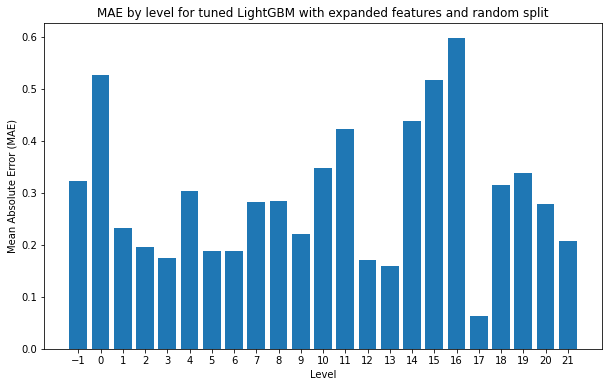

In [91]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for tuned LightGBM with expanded features and random split",
)

In [92]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.04
RMSE: 0.21

Round type: round
MSE: 0.05
RMSE: 0.23

Round type: 0.33
MSE: 0.05
RMSE: 0.23

Round type: 0.45
MSE: 0.04
RMSE: 0.21



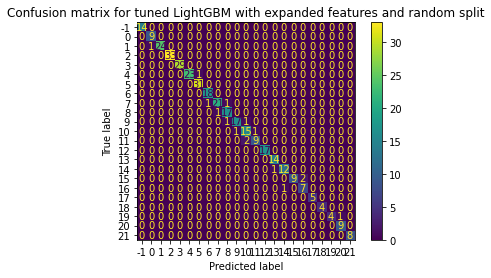

In [93]:
plot_confusion_matrix(
    "round",
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with expanded features and random split",
)

## Summary

In [94]:
results

,Split type,Tuning type,Set of features,MSE,RMSE,MAE
0,chronological,default,expanded,0.260866,0.510751,0.357177
1,chronological,Optuna,expanded,0.212029,0.460466,0.328358
2,random,default,expanded,0.148111,0.384853,0.267273
3,random,Optuna,expanded,0.115864,0.340387,0.233378


In [95]:
from training.results import plot_summary

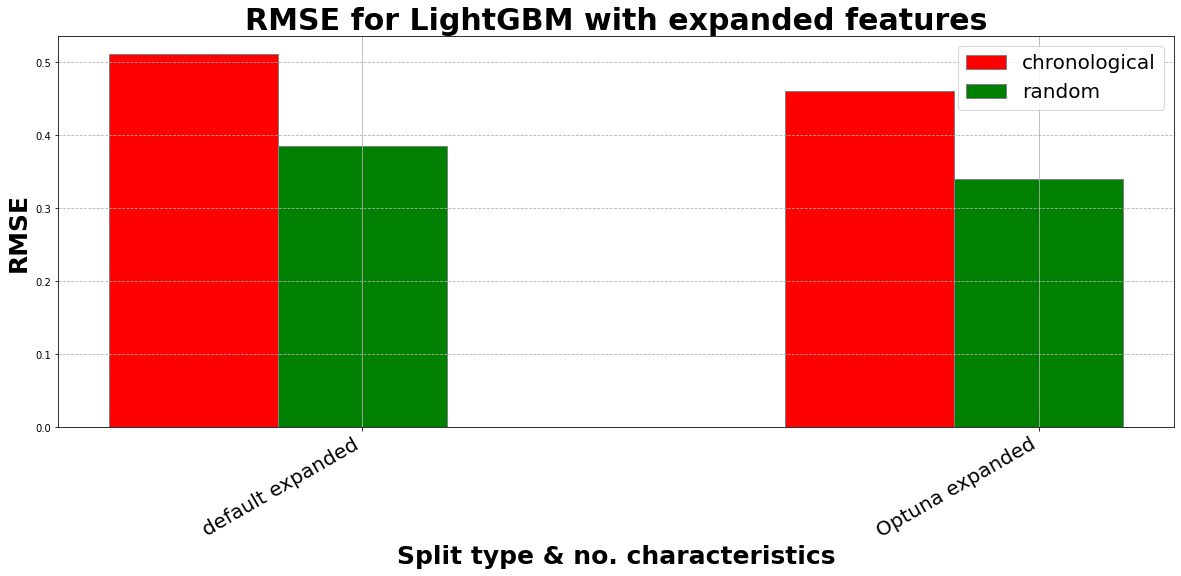

In [96]:
plot_summary(results, "RMSE", title="RMSE for LightGBM with expanded features")

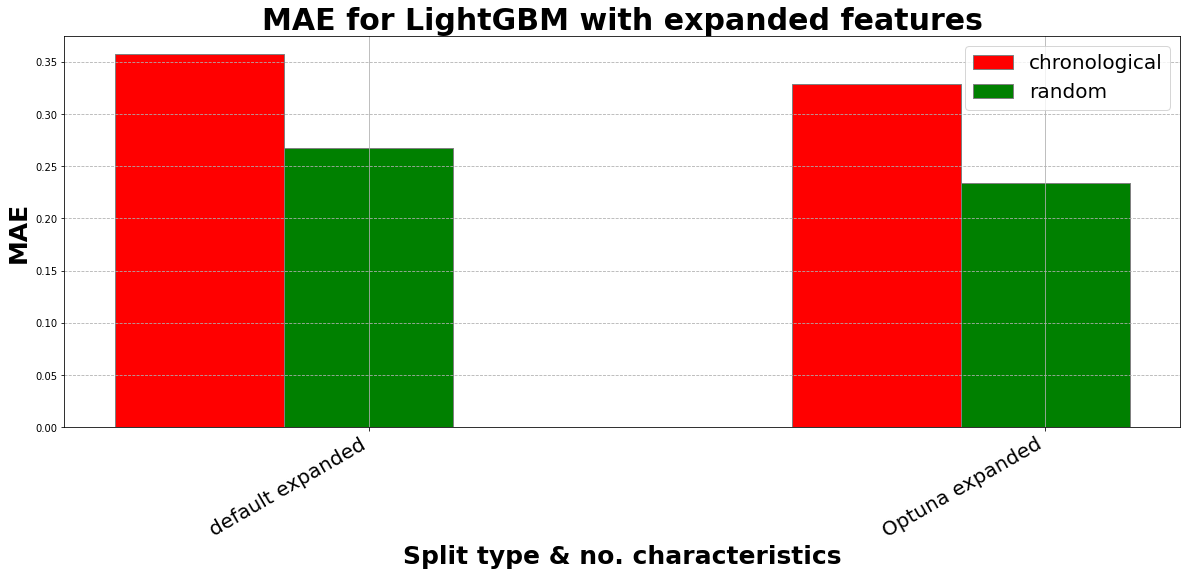

In [97]:
plot_summary(results, "MAE", title="MAE for LightGBM with expanded features")

In [98]:
results.to_json("./lightgbm_second_results.json")